# Tool实践——天气助手开发

In [1]:
import dotenv
from langchain_core.output_parsers import JsonOutputKeyToolsParser, StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_ollama import ChatOllama
from loguru import logger

from tools import get_weather

#加载环境变量配置
dotenv.load_dotenv()

#初始化大模型实例，使用qwen3:14b 模型
llm = ChatOllama(base_url="http://127.0.0.1:11434", model="qwen3:14b", reasoning=False)

#将模型与工具绑定，使其能够调用get_weather 工具
llm_with_tools = llm.bind_tools([get_weather])

#创建解析器，用于提取工具调用结果中的JSON 数据
parser = JsonOutputKeyToolsParser(key_name= get_weather.name, first_tool_only=True)

#构建工具调用链：模型->解析器->调用天气工具
get_weather_chain = llm_with_tools | parser | get_weather
# print(get_weather_chain.invoke("你好，请问南昌的天气怎么样？"))
#定义输出提示模板，将JSON天气数据转换为自然语言描述
output_prompt = PromptTemplate.from_template(
    """你将收到一段JSON格式的天气数据{weather_json}，请用简洁自然的方式将其转述给用户。
    一下是天气JSON数据：
    请将其转换为中文天气描述，例如：
    “北京现在气温：28℃，天气：晴，体感有点闷热（约32℃），湿度：75%，微风（东南风2米/秒），能见度很好，大约10公里。建议穿短袖短裤。适合做户外运动”
    """
)

# 创建字符串输出解析器
output_parser = StrOutputParser()

#构建最终输出链：提示词模板->模型->输出解析器
output_chain = output_prompt | llm | output_parser

#构建完整的处理链：天气查询链->将天气数据包装为字典格式->输出链
"""
 Lambda 在整个链中的作用：
 第一步：get_weather_chain
输入：{"question": "请问南昌今天天气怎么样？"}
处理：执行工具调用链
输出：{"weather":  "晴天", "temp": "28℃", "humidity": "75%"}
     ↓ 这个结果被传给 Lambda

第二步：Lambda 函数 (lambda x: {"weather_json":  x})
输入：{"weather": "晴天", "temp": "28℃", "humidity": "75%"}
处理：将整个输入打包成一个新字典，key 为 "weather_json"
输出：{"weather_json": {"weather": "晴天", "temp": "28℃", "humidity": "75%"}}
     ↓ 这个结果被传给 output_chain

第三步：output_chain
输入：{"weather_json": {... }}
处理：PromptTemplate 使用 {weather_json} 变量
输出："南昌现在天气晴朗，气温28℃，湿度75%..."

def transform_data(x):
    return {"weather_json": x}

# 用在链中：
full_chain = get_weather_chain | transform_data | output_chain
"""
full_chain = get_weather_chain | (lambda x:{"weather_json":x}) | output_chain

#执行完整链路，查询天气情况并打印结果
result = full_chain.invoke("请问南昌今天天气怎么样？")
logger.info(result)

2025-12-16 17:49:25.412 | INFO     | __main__:<module>:69 - 南昌现在气温：17℃，天气：多云，体感较凉爽（约16℃），湿度：29%，微风（东南风1.24米/秒），能见度很好，大约10公里。建议穿轻薄透气的衣物，适合户外活动。


# Agent实践——联网搜索问答

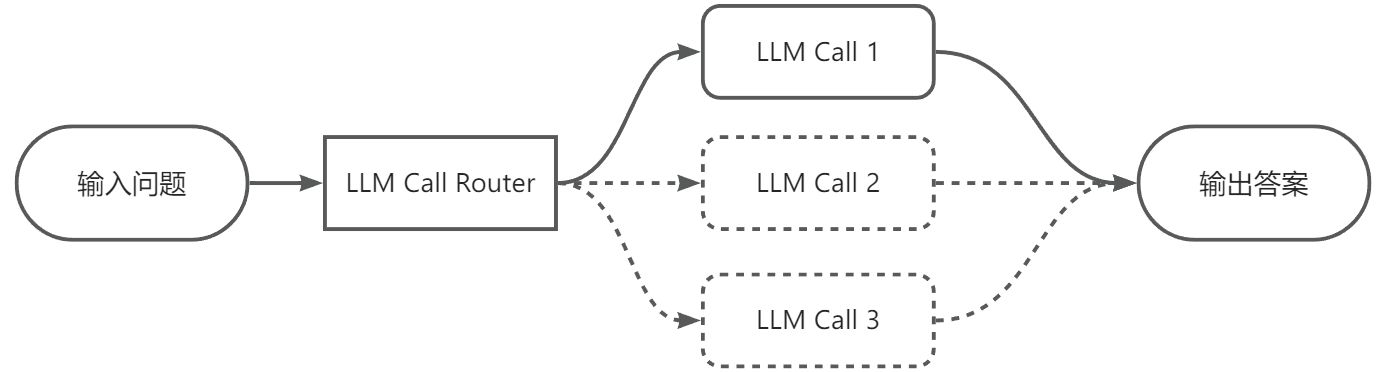

In [3]:
import os
import dotenv
from langchain_classic. agents import create_tool_calling_agent, AgentExecutor
from langchain_community.tools import GoogleSerperRun
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama import ChatOllama

# 加载环境变量配置文件
dotenv.load_dotenv()
# 从环境变量中获取Serper API密钥
api_key = os.getenv("SERPER_API_KEY")
# 创建Google Serper API包装器实例
api_wrapper = GoogleSerperAPIWrapper()

# 创建Google搜索工具实例
search_tool = GoogleSerperRun(api_wrapper=api_wrapper)
# 将搜索工具添加到工具列表中
tools = [search_tool]

# 定义聊天提示模板，包含系统角色设定、用户输入和代理执行过程占位符
prompt = ChatPromptTemplate.from_messages([
    ("system", "你是一名助人为乐的助手，并且可以调用工具进行网络搜索，获取实时信息。"),
    ("human", "{input}"),
    ("placeholder", "{agent_scratchpad}"),
])

# 创建Ollama聊天模型实例，使用qwen3:14b模型
llm = ChatOllama(base_url="http://127.0.0.1:11434", model="qwen3:14b", reasoning=False)

# 创建工具调用代理，整合语言模型、工具和提示模板
agent = create_tool_calling_agent(llm, tools, prompt)

# 创建代理执行器，用于执行代理并管理工具调用过程
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

# 调用代理执行器，传入用户查询问题
agent_executor.invoke({"input": "Apple最近发布的新品是什么？"})



> Entering new AgentExecutor chain...

Invoking: `google_serper` with `{'query': 'Apple最近发布的新品是什么？'}`


苹果计划在2026年春季发布iPhone 17e（内部代号V159），这是iPhone 16e的渐进式升级。据周二报道，iPhone 17e将配备玻璃后盖以支持无线充电，这是消费者在 ... 见见新一代iPhone，有iPhone 17 Pro、iPhone 17 和全新亮相的iPhone Air；听听全新AirPods Pro 3，入耳式主动降噪开启新声代；还有Apple Watch 系列新品，事关健康的各种 ... 來認識新一代iPhone 系列，iPhone 17 Pro、iPhone 17 以及全新亮相的iPhone Air。 探索全新AirPods Pro 3，體驗全球最佳入耳式主動消噪。 最新Apple Watch 系列，帶來最強健 ... ... 新品，進一步證實了外界多項傳聞。 AirTags 與家用設備. －AirTag 2（B589） －Apple Studio Display 2 顯示螢幕（J427、J527） －Apple TV（J355 ... 加利福尼亚州，库比提诺 Apple 今日首次发布了全新iPhone Air，这款史上最薄的iPhone 为用户带来专业级性能表现。iPhone Air 采用突破性钛金属设计，优雅 ... ... Apple TV 和HomePod mini 2 哪些是真香升級？哪些又只是炒冷飯？還有一個重要議題，未來不再支援Windows 10 的時候，平價MacBook 能「精準補位」嗎 ... 除了上述这些手机之外，苹果也将发布AirTag 2、搭载A18 Pro的入门级MacBook、搭载M5/M6芯片的Mac电脑与搭载A19处理器的iPad等平板电脑也在其中，可以说明年 ... 是的，那个前阵子被俄罗斯老哥开盒的M5 iPad Pro 也在今晚发布了，售价8999 元起，而配置拉满的2TB 版本售价则来到了让人咋舌的22499 元。 总的来看，可以看到苹果自研的GPU 在 ... 來認識新一代iPhone 系列，iPhone 17 Pro、iPhone 17 與全新iPhone Air 矚目登場。探

{'input': 'Apple最近发布的新品是什么？',
 'output': '根据最近的报道，苹果计划发布的新品包括：\n\n1. **iPhone 17系列**：包括标准版iPhone 17、iPhone 17 Pro、iPhone 17 Pro Max，以及全新推出的iPhone 17 Air。iPhone 17 Air将取代现有的Plus机型，采用钛金属设计，是史上最薄的iPhone，提供专业级性能表现。\n\n2. **AirPods Pro 3**：配备全球最佳入耳式主动降噪技术，带来全新的音频体验。\n\n3. **Apple Watch 系列新品**：带来更强大的健康功能。\n\n4. **AirTag 2**：新一代的AirTag，提升追踪功能。\n\n5. **Apple Studio Display 2**：全新升级的显示设备。\n\n6. **Apple TV**：更新版本的Apple TV，提升性能与体验。\n\n7. **MacBook 和 Mac 电脑**：包括搭载A18 Pro的入门级MacBook、搭载M5/M6芯片的Mac电脑。\n\n8. **iPad**：搭载A19处理器的新一代iPad，包括高端的M5 iPad Pro，价格从8999元起，2TB版本高达22499元。\n\n这些新品进一步巩固了苹果在多个领域的领先地位，并展示了其创新能力和技术实力。'}

# Agent实践——浏览器自动化
刚刚使用的create_tool_calling_agent方法，它其实在langChain中是一个通用的用来构建工具代理的方法，除此以外，langChain还封装了非常多种不同的Agent实现形式，大家可以在这个链接中查看到所有LangChain中已经集成的Agent实现形式：

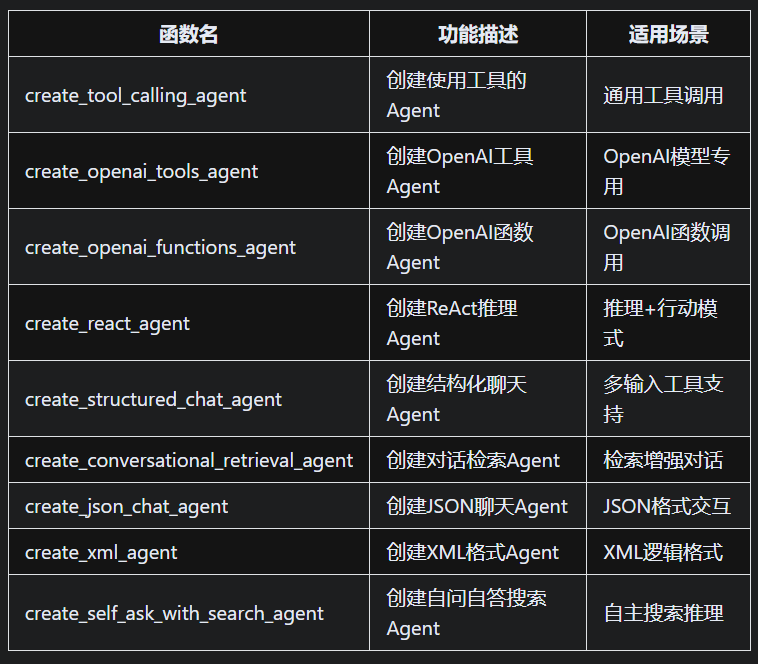

其中<font color="red">比较通用场景的就是我们刚刚使用的create_tool_calling_agent</font>，而对于一些符合OpenAI API RESTFUL API的模型，则同样可以使用create_openai_tools_agent，另外像create_react_agent可以用于一些推理任务，create_conversational_retrieval_agent则可以用于一些对话系统，具体还是需要根据实际需求来选择。

|          对比项          |     create_react_agent      |  create_openai_tools_agent  |
|:---------------------:|:---------------------------:|:---------------------------:|
|         核心机制          |   基于ReAct推理框架（思考->行动->观察）   |   基于OpenAI Tool Calling协议   |
| 是否以来Function Calling  |              否              |              是              |
|        支持模型范围         | 任意聊天模型（包括本地模型，如Ollama、vLLM） | 仅支持OpenAI支持工具调用的模型（如GPT-4o） |
|         推理方式          |          多轮思维链、可解释          |         单轮结构化调用、高效          |
|          优点           |          逻辑透明、可控性高          |         调用高效、接口原生支持         |
|         适用场景          |       本地/自定义模型、多步复杂推理       | OpenAI模型、标准工具调用流程、MCP客户端调用  |

在大模型应用开发领域有非常多的需求场景，其中一个比较热门的就是浏览器自动化，通过自动化提取网页内容，然后进行分析，最后生成报告。这样的流程提升效率和收集信息的有效途径。因此接下来，我们就尝试使用尝试使用

create_openai_tools_agent来实际开发一个浏览器自动化代理。代码如下：

In [23]:
## 此代码在Jupyter中无法运行，已经保存在playwright_agent_sync.py文件中

import dotenv
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_sync_playwright_browser
from langchain_classic import hub
from langchain_classic.agents import AgentExecutor, create_openai_tools_agent
from langchain_ollama import ChatOllama

# 加载环境变量配置文件
dotenv.load_dotenv()

# 创建同步Playwright浏览器实例
sync_browser = create_sync_playwright_browser()

# 从浏览器实例创建PlayWright工具包
toolkit = PlayWrightBrowserToolkit.from_browser(sync_browser=sync_browser)

# 获取工具包中的所有工具
tools = toolkit.get_tools()

# 从Hub拉取OpenAI工具代理的提示模板
prompt = hub.pull("hwchase17/openai-tools-agent")

# 创建ChatOllama语言模型实例，使用qwen3:14b模型
llm = ChatOllama(model="qwen3:14b", reasoning=False)

# 创建OpenAI工具代理，整合语言模型、工具和提示模板
agent = create_openai_tools_agent(llm, tools, prompt)

# 创建代理执行器，用于执行代理任务并管理工具调用
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)


if __name__ == "__main__":
    # 定义任务
    command = {
        "input": "访问这个网站https://www.cuiliangblog.cn/detail/section/227788709 并帮我总结一下这个网站的内容"
    }

    # 执行任务
    response = agent_executor.invoke(command)
    print(response)

C:\Users\admin\miniconda3\envs\py313\Lib\site-packages\pygments\regexopt.py:78: RuntimeWarning: coroutine 'PlaywrightContextManager.start' was never awaited
  for group in groupby(strings, lambda s: s[0] == first[0])) \


Error: It looks like you are using Playwright Sync API inside the asyncio loop.
Please use the Async API instead.

 如果使用create_react_agent，只需要修改 prompt 和 agent_executor 即可

# 组合 LCEL 链实现浏览器自动化

更进一步地，我们还可以将Playwright Agent封装成工具函数，并结合LangChain的LCEL串行链，实现一个更加复杂的浏览器自动化代理。代码如下：

In [ ]:
from datetime import datetime
import dotenv
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_sync_playwright_browser
from langchain_classic import hub
from langchain_classic.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langchain_ollama import ChatOllama

# 加载环境变量配置文件
dotenv.load_dotenv()


@tool
def summarize_website(url: str) -> str:
    """
    访问指定网站并返回内容总结。

    参数:
        url (str): 要访问和总结的网页URL。

    返回:
        str: 网页正文内容的总结，若失败则返回错误信息。
    """
    try:
        # 创建同步Playwright浏览器实例
        sync_browser = create_sync_playwright_browser()

        # 从浏览器实例创建PlayWright工具包
        toolkit = PlayWrightBrowserToolkit.from_browser(sync_browser=sync_browser)

        # 获取工具包中的所有工具
        tools = toolkit.get_tools()

        # 从Hub拉取OpenAI工具代理的提示模板
        prompt = hub.pull("hwchase17/openai-tools-agent")

        # 创建ChatOllama语言模型实例，使用qwen3:8b模型
        llm = ChatOllama(model="qwen3:8b", reasoning=False)

        # 创建OpenAI工具代理，整合语言模型、工具和提示模板
        agent = create_openai_tools_agent(llm, tools, prompt)

        # 创建代理执行器，用于执行代理任务并管理工具调用
        agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)
        command = {
            "input": f"访问这个网站 {url} 并帮我详细总结这个网页的正文内容，评论交流区、版权信息、友情链接等其他内容不要总结。"
        }
        result = agent_executor.invoke(command)
        return result.get("output", "无法获取网站内容总结")

    except Exception as e:
        return f"网站访问失败: {str(e)}"


@tool
def save_file(summary: str) -> str:
    """
    将文本内容生成为md文件。

    参数:
        summary (str): 需要保存为文件的内容。

    返回:
        str: 保存成功的文件名路径信息。
    """
    filename = f"summary_{datetime.now().strftime('%Y%m%d_%H%M%S')}.md"
    with open(filename, "w", encoding="utf-8") as f:
        f.write("# 网页内容总结\n\n")
        f.write(summary)
    return f"已保存至 {filename}"


# 初始化格式化语言模型
format_llm = ChatOllama(model="qwen3:8b", reasoning=False)

# 定义格式化提示模板，用于优化总结内容以适应MD文件格式
format_prompt = ChatPromptTemplate.from_template(
    """请优化以下网站总结内容，使其更适合MD文件格式：

    原始总结：
    {summary}

    优化后的内容："""
)

# 创建字符串输出解析器
format_parser = StrOutputParser()

# 构建格式化处理链：模板 -> 模型 -> 解析器
format_chain = format_prompt | format_llm | format_parser

# 构建主流程链：网站总结 -> 格式化 -> 保存文件
chain = (
        summarize_website
        | (lambda summary: {"summary": summary})
        | format_chain
        | save_file
)

# 执行整个流程链，传入目标URL进行网站内容总结与保存
chain.invoke({"url": "https://www.cuiliangblog.cn/detail/section/227788709"})


#
##
###

|12|23|
|22|22|